# Семинар № 1 - kNN, Bayes
---
Урок основан на открытых материалах [Evgeny Sokolov](https://github.com/esokolov) и [YSDA](https://github.com/yandexdataschool).

# Загрузка данных

In [5]:
# базовый набор для обработки даннных
import numpy as np
import pandas as pd

# отображение данных
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# данные и алгоритмы ML
from sklearn import datasets

%matplotlib inline
%load_ext autoreload
%autoreload 2

matplotlib.rcParams['font.size'] = 11
matplotlib.style = 'seaborn'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Сначала для загрузки набора данных мы будем использовать пакет [`sklearn`](https://scikit-learn.org/stable/), который будем активно использовать на протяжении всего курса.

sklearn реализует большинство классических и часто используемых алгоритмов машинного обучения. Также он предоставляет [Руководство пользователя] (https://scikit-learn.org/stable/user_guide.html), описывающее принципы каждой группы реализованных алгоритмов.

В качестве отправной точки для основных концепций sklearn мы рекомендуем [руководство по началу работы] (https://scikit-learn.org/stable/getting_started.html) (проверьте сами). [Дополнительные руководства] (https://scikit-learn.org/stable/tutorial/index.html) также могут быть полезны для развития ваших навыков.

Первая функциональность, которую мы используем, — удобная загрузка [общих наборов данных] (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). Все, что нам нужно сделать, это всего лишь один вызов функции.

Объект, сгенерированный [`load_iris`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html), описывается как:

> Объект, похожий на словарь, интересные атрибуты:
>
> «данные», данные для изучения,
>
> «цель», классификационные метки,
>
>‘target_names’, значение меток,
>
>‘feature_names’, значение функций,
>
> «DESCR», полное описание набора данных,
>
> «имя файла», физическое расположение набора данных CSV радужной оболочки (добавлено в версии 0.20)

Посмотрим, что у нас есть

In [6]:
dataset = datasets.load_iris()

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Если вы не знакомы с набором данных Iris - найдите минутку, чтобы прочитать описание выше =) (как всегда [подробнее об этом в Википедии](https://en.wikipedia.org/wiki/Iris_flower_data_set))

__TL;DR__ 150 объектов, равномерно распределенных по 3 классам, каждый из которых описан 4 непрерывными функциями.

In [7]:
# пока не нужно разбираться, что происходит в этом коде - просто посмотрите на таблицу

ext_target = dataset.target[:, None]
pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'],
)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


Теперь дайте разные имена данным, которые мы будем использовать.

In [8]:
features = dataset.data
target = dataset.target

features.shape, target.shape

((150, 4), (150,))

__Пожалуйста, помните!!!__

В любом месте нашего курса у нас есть соглашение формировать матрицу дизайна (названную «функциями» в приведенном выше коде) как

`(#number_of_items, #number_of_features) - (#кол-во данных, #кол-во характеристик)`

## Визуализация данных

Наш набор данных имеет 4 измерения, однако люди чаще используют трехмерные или даже двухмерные данные, поэтому давайте нанесем первые 3 функции, окрашенные значениями меток.

In [9]:
from mpl_toolkits.mplot3d import Axes3D

C:\Users\Michail\AppData\Local\Temp\ipykernel_2308\332545979.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


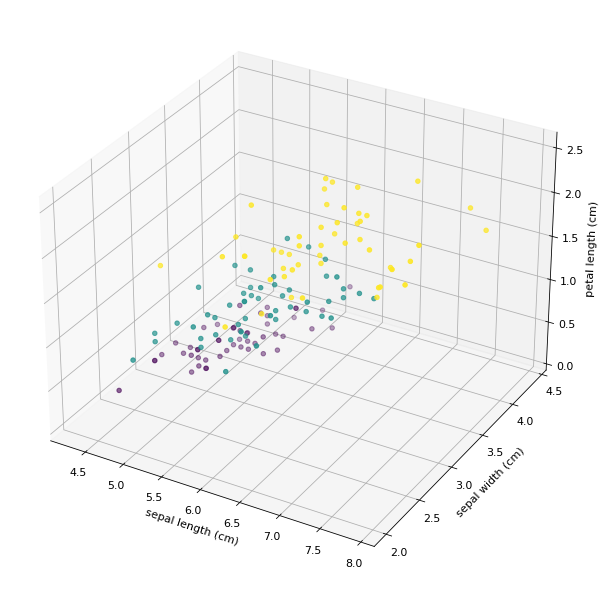

In [10]:
fig = plt.figure(figsize=(8, 8))

ax = Axes3D(fig)

ax.scatter(features[:, 0], features[:, 1], features[:, 3], c=target, marker='o')
ax.set_xlabel(dataset.feature_names[0])
ax.set_ylabel(dataset.feature_names[1])
ax.set_zlabel(dataset.feature_names[2])

plt.show()

In [11]:
# сформируем датасет
X = pd.DataFrame(features, columns=dataset['feature_names'])

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [12]:
print(dataset['target_names'])
y = target
y

['setosa' 'versicolor' 'virginica']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [13]:
df = X.copy()
df['target'] = y

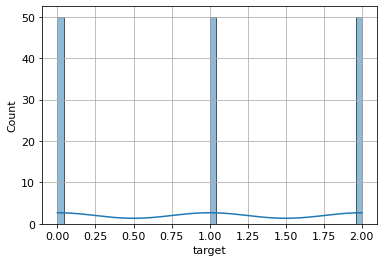

In [14]:
# нарисуем распределение меток

sns.histplot(x='target', data=df, bins=50, kde=True)
plt.xlabel('target')
plt.grid()
plt.show()

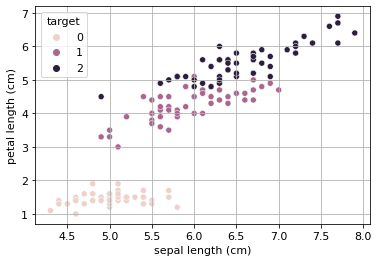

In [15]:
sns.scatterplot(x='sepal length (cm)', y='petal length (cm)', hue='target', data=df)
plt.grid()
plt.show()

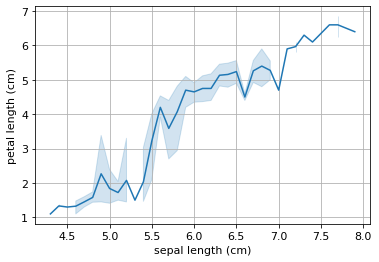

In [16]:
sns.lineplot(data=df, x="sepal length (cm)", y="petal length (cm)")
plt.grid()
plt.show()

Затем посмотрите на распределения функций

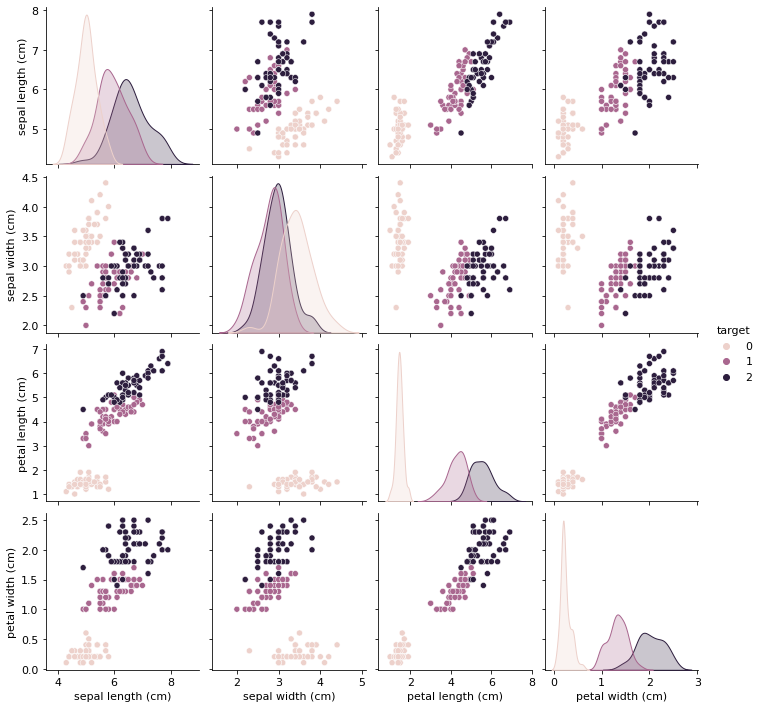

In [17]:
sns.pairplot(data=df, hue='target')
plt.show()

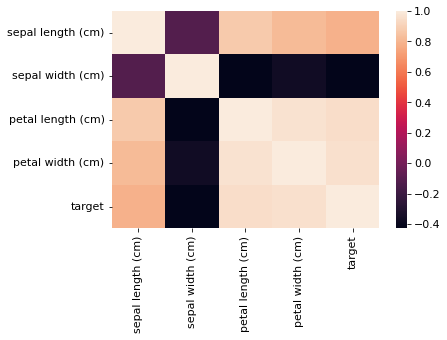

In [18]:
sns.heatmap(df.corr())
plt.show()

Обратите внимание, что каждый график выше имеет собственный масштаб

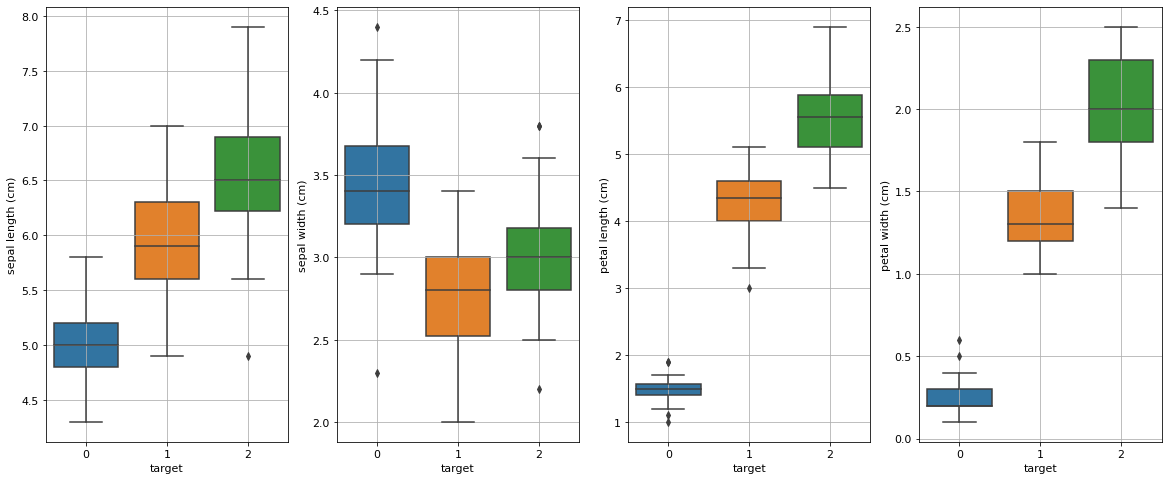

In [19]:
plt.figure(figsize=(20 , 8))

for i, col in enumerate(X.columns):
    plt.subplot(1, len(X.columns), i + 1)
    sns.boxplot(y=col, x='target', data=df)
    plt.grid()
    
plt.show()

# Naive Bayes Classifier

Поскольку мы стремимся сначала реализовать алгоритм наивного Байеса, нам нужно определить некоторое предварительное распределение.

Наиболее распространенное распределение (конечно) гауссово, и его параметры - среднее значение и стандартное отклонение. Давайте реализуем класс, принимающий список значений признаков, оценивающий параметры распределения и способный дать плотность вероятности любого заданного значения признака.

Обозначим нормальное распределение $\mathcal{N}(\mu, \sigma^2)$ PDF:
$$
f(x|\mu, \sigma^2) = \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^ 2})
$$
Давайте реализуем класс GaussianDistribution. (Конечно, на практике всегда можно использовать что-то вроде `scipy.stats.norm`).

Обратите внимание, что выполнение вычислений с логарифмическими вероятностями более стабильно.

In [26]:
class GaussianDistribution:
    def __init__(self, feature):
        '''
        Args:
            feature: column of design matrix, represents all available values
                of feature to model.
                axis=0 stays for samples.
        '''
        self.mean = feature.mean(axis=0)
        self.std = feature.std(axis=0)

    def logpdf(self, value):
        '''Logarithm of probability density at value'''
        return -0.5 * np.log(self.std ** 2 * 2 * np.pi) - (value - self.mean) ** 2 / (2 * self.std ** 2)
    
    def pdf(self, value):
        return np.exp(self.logpdf(value))
    
    def __repr__(self):
        return f'GaussianDistribution, mu={self.mean:.4f}, std={self.std:.4f}'

Проверяем результат:

In [27]:
import scipy

In [28]:
_test = scipy.stats.norm(loc=features[:, :2].mean(axis=0), scale=features[:, :2].std(axis=0))

assert np.allclose(
    GaussianDistribution(features[:, :2]).logpdf(features[:5, :2]),
    _test.logpdf(features[:5, :2])
)
print('Seems fine!')

Seems fine!


Давайте теперь сосредоточимся на проблеме классификации. Для класса $K$ пометьте $y_i \in \{C_1, \ldots, C_k\}$. Задача классификации радужной оболочки имеет 3 класса, поэтому $K=3$. Теорема Байеса принимает следующий вид:

$$
P(y_i = C_k|\mathbf{x}_i) = \frac{P(\mathbf{x}_i|y_i = C_k) P(y_i = C_k)}{P(\mathbf{x}_i)}
$$

Обратите внимание, что здесь мы также предпочитаем работать с логарифмическими вероятностями. Таким образом, приведенное выше уравнение примет следующий вид:
$$
\log P(y_i = C_k|\mathbf{x}_i) = \log P(\mathbf{x}_i|y_i = C_k) + \log P(y_i = C_k) - \log P(\mathbf{x} _я)
$$

Как можно заметить, для нахождения метки класса с наибольшей вероятностью нам даже не нужен последний член $P(\mathbf{x}_i)$. Однако это необходимо для получения правильной оценки вероятности $P(y_i = C_k|\mathbf{x}_i)$. Член $P(\mathbf{x}_i)$ можно вычислить, используя следующее свойство:
$$
P(\mathbf{x}_i) = \sum_{k=1}^K P(\mathbf{x}_i|y_i=C_k).
$$
Его можно вычислить из значений $\log P(\mathbf{x}_i|y_i=C_k)$ с помощью функции `logsumexp`, расположенной в `scipy.special`.

Теперь давайте реализуем сам классификатор Naive Bayes. Приведенный ниже класс унаследован от базовых классов ```sklearn``` и предоставляет все основные методы.

In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import logsumexp

In [ ]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    '''
    Обратите внимание, что использование `X` и `y` для матрицы дизайна и меток в целом не является хорошим выбором,
    лучше придерживаться более информативных соглашений об именах.
    Однако, чтобы сделать код совместимым с реализацией sklearn, мы используем здесь переменные `X` и `y`.
    '''
    def fit(self, X, y, sample_weight=None, distributions=None):
        '''
        sample_weight 
            The argument is ignored. For comatibility only.
        '''
        self.unique_labels = np.unique(y)
        
        # If distributions of features are not specified, they a treated Gaussian
        if distributions is None:
            distributions = [GaussianDistribution] * X.shape[1]
        else:
            # Check whether distributions are passed for all features
            assert len(distributions) == X.shape[1]        

        # Здесь мы находим параметры распределения для каждой функции в каждом подмножестве классов
        # поэтому P(x^i|y=C_k) будет оцениваться только с использованием информации из i-го признака значений класса C_k
        self.conditional_feature_distributions = {} # label: [distribution for feature 1, ...]
        for label in self.unique_labels:
            feature_distribution = []
            for column_index in range(X.shape[1]):
                # `column_index` feature values for objects from `label` class
                feature_column = X[y == label, column_index]
                fitted_distr = distributions[column_index](feature_column)
                feature_distribution.append(fitted_distr)
            self.conditional_feature_distributions[label] = feature_distribution

        # Prior label distributions (unconditional probability of each class)
        self.prior_label_distibution = {
            # <YOUR CODE HERE>
        }

    def predict_log_proba(self, X):
        # Matrix of shape (n_objects : n_classes)
        class_log_probas = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        
        # Здесь мы вычисляем логарифмические вероятности класса для каждого класса последовательно
        for label_idx, label in enumerate(self.unique_labels):
            for idx in range(X.shape[1]):
                # Вся логарифмическая вероятность для каждого признака -- фиксированная метка
                class_log_probas[:, label_idx] += self.conditional_feature_distributions[label][idx].logpdf(X[:, idx]) # <YOUR CODE HERE>

            # Add log proba of label prior
            class_log_probas[:, label_idx] += np.log(self.prior_label_distibution[label]) # <YOUR CODE HERE>

        for idx in range(X.shape[1]):
            # Если вы хотите получить вероятности, вам нужно вычесть логарифмическую вероятность для каждой функции
            class_log_probas -= logsumexp(class_log_probas, axis=1)[:, None] # <YOUR CODE HERE>
        return class_log_probas
    
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    def predict(self, X):
        log_probas = self.predict_log_proba(X)
        # нам нужно привести метки к их первоначальному виду (они могут начинаться с числа, отличного от 0)
        return np.array([self.unique_labels[idx] for idx in log_probas.argmax(axis=1)])
    

In [ ]:
nb = NaiveBayes()
nb.fit(features, target)

print('log probas:\n{}'.format(nb.predict_log_proba(features[:2])))
print('predicted labels:\n{}'.format(nb.predict(features[:2])))
print('\nIt`s alive! More tests coming.')

In [ ]:
nb.conditional_feature_distributions

In [ ]:
nb.prior_label_distibution

Теперь давайте проверим наш наивный байесовский классификатор на необработанных данных. Для этого мы будем использовать `train_test_split` из `sklearn`.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25)

print(features_train.shape, features_test.shape)

In [ ]:
nb = NaiveBayes()
nb.fit(features_train, target_train, distributions=[GaussianDistribution]*4)
nb_test_log_proba = nb.predict_log_proba(features_test)

In [ ]:
print('Naive Bayes classifier accuracy on the train set: {}'.format(nb.score(features_train, target_train)))

In [ ]:
print('Naive Bayes classifier accuracy on the test set: {}'.format(nb.score(features_test, target_test)))

Наконец, давайте сравним наивный байесовский классификатор с реализациями ```sklearn```.

In [ ]:
from sklearn import naive_bayes

In [ ]:
sklearn_nb = naive_bayes.GaussianNB()
sklearn_nb.fit(features_train, target_train)
sklearn_nb_test_log_proba = sklearn_nb.predict_log_proba(features_test)

In [ ]:
print('sklearn implementation accuracy on the train set: {}'.format(sklearn_nb.score(features_train, target_train)))

In [ ]:
print('sklearn implementation accuracy on the test set: {}'.format(sklearn_nb.score(features_test, target_test)))

Проверим прогнозы. Если вы использовали распределение Гаусса и все сделали правильно, логарифмические вероятности должны быть одинаковыми.

In [ ]:
assert np.allclose(nb_test_log_proba, sklearn_nb_test_log_proba), 'log probabilities do not match'
print('Seems alright!')

# kNN - метод ближайших соседей

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X[['sepal length (cm)', 'petal length (cm)']], y,
                                                    train_size=0.8, test_size=0.2,
                                                    shuffle=True, random_state=42)

In [32]:
X_train.shape, X_test.shape

((120, 2), (30, 2))

In [33]:
knn = KNeighborsClassifier() # По умочанию - 5 соседей и Евклидова метрика

In [34]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [35]:
pred = pd.DataFrame(knn.predict(X_test), columns=['predict'])
pred['test'] = y_test

In [36]:
pred.head()

,predict,test
0,1,1
1,0,0
2,2,2
3,1,1
4,1,1


In [37]:
accuracy_score(knn.predict(X_test), y_test)

0.9666666666666667

In [38]:
knn = KNeighborsClassifier(1)
knn.fit(X_train, y_train)
accuracy_score(knn.predict(X_test), y_test)

0.9333333333333333

In [39]:
knn = KNeighborsClassifier(80)
knn.fit(X_train, y_train)
accuracy_score(knn.predict(X_test), y_test)

0.6333333333333333

#### Ваш ход...

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Примените kNN для данных по всем признакам, какую метрику качества на тесте вы достигаете? 

# <YOUR CODE HERE>

## kNN from scratch

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

In [40]:
from sklearn.datasets import load_digits

## Загрузим и визуализируем данные

In [41]:
dataset = datasets.load_digits()

print(dataset.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [42]:
features = dataset.data
target = dataset.target

features.shape, target.shape

((1797, 64), (1797,))

In [43]:
train_X, test_X, train_y, test_y = train_test_split(features, target, test_size=0.25)

print(train_X.shape, train_y.shape)

(1347, 64) (1347,)


In [44]:
test_X

array([[ 0.,  0.,  7., ...,  2.,  0.,  0.],
       [ 0.,  0.,  2., ..., 16., 16.,  7.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  4., ..., 14.,  3.,  0.],
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

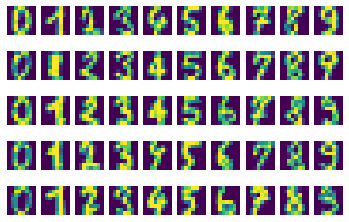

In [45]:
samples_per_class = 5  # Number of samples per class to visualize
plot_index = 1

for example_index in range(samples_per_class):
    for class_index in range(10):
        plt.subplot(5, 10, plot_index)
        image = train_X[train_y == class_index][example_index].reshape((8,8))
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1

## Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [46]:
# Сначала подготовим метки и исходные данные

# Выберите только 0 и 9
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
binary_test_y = test_y[binary_test_mask] == 0

# Преобразование в одномерный массив [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)

In [47]:
binary_train_X.shape, binary_train_y.shape

((259, 64), (259,))

In [48]:
binary_test_X.shape, binary_test_y.shape

((99, 64), (99,))

In [54]:
import numpy as np
from numpy.linalg import norm


class KNN:
    """
    K-neariest-neighbor classifier using L1 loss
    """
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.train_X = X
        self.train_y = y

    def predict(self, X, num_loops=2):
        '''
        Uses the KNN model to predict clases for the data samples provided
        
        Arguments:
        X, np array (num_samples, num_features) - samples to run
           through the model
        num_loops, int - which implementation to use

        Returns:
        predictions, np array of ints (num_samples) - predicted class
           for each sample
        '''
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        else:
            dists = self.compute_distances_two_loops(X)

        if self.train_y.dtype == bool:
            return self.predict_labels_binary(dists)
        else:
            return self.predict_labels_multiclass(dists)

    def compute_distances_two_loops(self, X):
        '''
        Computes L1 distance from every sample of X to every training sample
        Uses simplest implementation with 2 Python loops

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        
        for i_test in range(num_test):
            for i_train in range(num_train):
                dists[i_test, i_train] = norm(self.train_X[i_train] - X[i_test])
                
        return dists
    
    def compute_distances_one_loop(self, X):
        '''
        Computes L1 distance from every sample of X to every training sample
        Vectorizes some of the calculations, so only 1 loop is used

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        for i_test in range(num_test):
            dists[i_test, :] = norm(self.train_X - X[i], axis=1)
            
        return dists

    def compute_distances_no_loops(self, X):
        '''
        Computes L1 distance from every sample of X to every training sample
        Fully vectorizes the calculations using numpy

        Arguments:
        X, np array (num_test_samples, num_features) - samples to run
        
        Returns:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample
        '''
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train), dtype=np.float32) 

        dists = -2 * X @ self.X_train.T
        dists += np.array([np.sum(X ** 2, axis=1)]).T
        dists += np.array([np.sum(self.X_train ** 2, axis=1)])

        return np.sqrt(dists)

    def predict_labels_binary(self, dists):
        '''
        Returns model predictions for binary classification case
        
        Arguments:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample

        Returns:
        pred, np array of bool (num_test_samples) - binary predictions 
           for every test sample
        '''
        num_test = dists.shape[0]
        pred = np.zeros(num_test, bool)
        for i in range(num_test):            
            ind = np.argsort(dists[i])[:self.k]
            closest_y = self.y_train[ind]
            
            pred[i] = np.argmax(np.bincount(closest_y))
            
        return pred

    def predict_labels_multiclass(self, dists):
        '''
        Returns model predictions for multi-class classification case
        
        Arguments:
        dists, np array (num_test_samples, num_train_samples) - array
           with distances between each test and each train sample

        Returns:
        pred, np array of int (num_test_samples) - predicted class index 
           for every test sample
        '''
        num_test = dists.shape[0]
        pred = np.zeros(num_test, int)
        for i in range(num_test):            
            ind = np.argsort(dists[i])[:self.k]
            closest_y = self.y_train[ind]
            
            pred[i] = np.argmax(np.bincount(closest_y))
            
        return pred

In [55]:
# Создайте классификатор и вызовите его для обучения модели
# KNN просто запоминает все данные

knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

In [58]:
# TODO: implement compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sqrt(np.sum(np.abs(binary_test_X[0] - binary_train_X[10]))))

AssertionError: 

In [ ]:
# TODO: implement compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
# TODO: implement compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

In [ ]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

In [ ]:
# TODO: implement predict_labels_binary
prediction = knn_classifier.predict(binary_test_X)

In [ ]:
a = np.array([True, False, False, True, True])
unique, counts = np.unique(a, return_counts=True)
unique[np.argmax(counts)]

In [ ]:
def binary_classification_metrics(prediction, ground_truth):
    '''
    Вычисляет метрики для бинарной классификации
    Аргументы:
     prediction, np массив bool (num_samples) - предсказания модели
     ground_truth, np массив bool (num_samples) - истинные метки
    Возвращает:
     точность, отзыв, f1, точность - показатели классификации
    '''
    tp = np.sum([(prediction[i] == True and ground_truth[i] == True) for i in range(prediction.shape[0])])
    tn = np.sum([(prediction[i] == False and ground_truth[i] == False) for i in range(prediction.shape[0])])
    fp = np.sum([(prediction[i] == True and ground_truth[i] == False) for i in range(prediction.shape[0])])
    fn = np.sum([(prediction[i] == False and ground_truth[i] == True) for i in range(prediction.shape[0])])
            
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fn + fp)
    f1 = 2 * tp / (2 * tp + fp + fn )
    
    return precision, recall, f1, accuracy

In [ ]:
# TODO: implement binary_classification_metrics
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

In [ ]:
# Давайте соберем все вместе и запустим KNN с k=3 и посмотрим, что у нас получится

knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение параметра k для алгоритма KNN! 

Для этого мы воспользуемся k-fold [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [ ]:
# Найдите лучший k, используя перекрестную проверку на основе оценки F1
# TODO: разделить тренировочные данные на 5 частей и сохранить их в train_folds_X/train_folds_y
num_folds = 5

train_folds_X = # <YOUR CODE>
train_folds_y = # <YOUR CODE>

k_choices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 50]
k_to_f1 = {}  # отображает значения k в F1 (int -> float)

In [ ]:
[x[0].shape for x in train_folds_X]

In [ ]:
for k in k_choices:
    _f1 = np.zeros(num_folds)
    for fold in range(num_folds):
        _train_x = np.concatenate(np.delete(train_folds_X[:], fold, 0))
        _test_x = train_folds_X[fold]
        _train_y = np.concatenate(np.delete(train_folds_y[:], fold, 0))
        _test_y = train_folds_y[fold]
        knn = KNN(k)
        knn.fit(_train_x, _train_y)
        prediction = knn.predict(_test_x)
        _, _, f1, _ = binary_classification_metrics(prediction, _test_y)
        _f1[fold] = f1
    k_to_f1.update({k : sum(_f1) / num_folds})

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [ ]:
# TODO: Установите лучший k на лучшее значение, найденное перекрестной проверкой

best_k = None # <YOUR CODE HERE>

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [ ]:
# Теперь давайте использовать все 10 классов

train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [ ]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [ ]:
def multiclass_accuracy(predictions, ground_truth):
    accuracy = None # <YOUR CODE HERE>
    
    return accuracy

In [ ]:
# TODO: Implement multiclass_accuracy

accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [ ]:
%%time
# Найдите лучший k, используя перекрестную проверку на основе точности
# TODO: разделить тренировочные данные на 5 частей и сохранить их в train_folds_X/train_folds_y

num_folds = 5
train_folds_X = # <YOUR CODE>
train_folds_y = # <YOUR CODE>


k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}

for k in k_choices:
    _acc = np.zeros(num_folds)
    for fold in range(num_folds):
        _train_x = np.concatenate(np.delete(train_folds_X[:], fold, 0))
        _test_x = train_folds_X[fold]
        _train_y = np.concatenate(np.delete(train_folds_y[:], fold, 0))
        _test_y = train_folds_y[fold]
        knn = KNN(k)
        knn.fit(_train_x, _train_y)
        prediction = knn.predict(_test_x)
        acc = multiclass_accuracy(prediction, _test_y)
        _acc[fold] = acc
    k_to_accuracy.update({k : sum(_acc)/num_folds})


for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))

### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

In [ ]:
# TODO: Установите лучший k на лучшее значение, найденное перекрестной проверкой

best_k = None # <YOUR CODE HERE>

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

accuracy = multiclass_accuracy(prediction, test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f" % accuracy)